In [2]:
# Imports
from utils import read_json_file, write_json_file, read_json_file_or_empty_list
from utils import large_num_short_format
from dotenv import load_dotenv
from typing import  List, Dict
from utils import print_progress
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import  math

load_dotenv()

True

In [3]:
# Load AUTO charts and convert them to daily 
from download_chart_data import ChartInterval
from download_chart_data import load_chart_by_interval, chart_data_to_df
from download_candles import load_candles_by_interval, CandleInterval


daily_candles = load_candles_by_interval(CandleInterval.DAILY)
print("\nDaily candles count: {}".format(len(daily_candles)))
charts = load_chart_by_interval(ChartInterval.FULL)
print("\nCharts count: {}".format(len(charts)))

 Loading candles_daily idx: 10425 / 10426, 100.0%       
Daily candles count: 9796
 Loading chart_full idx: 10424 / 10425, 100.0%       
Charts count: 9887


In [4]:
# Transform charts to data frame
df_charts: Dict[str, pd.DataFrame] = dict()
total = len(charts)

for idx, key in enumerate(charts):
    chart = charts[key]
    df_charts[key] = chart_data_to_df(chart)
    print_progress("Transforming charts to dataframe ", idx, total, True)

 Transforming charts to dataframe  idx: 9886 / 9887, 100.0%       

In [5]:
from download_candles import daily_candle_data_to_df
# Find pumps for candles
from download_chart_data import chart_data_to_df
from utils import print_progress, year_month_str
import pandas as pd
import  math


def is_pump(
    open: float, high: float, pump_ratio: float, min_volume: float, volume: float
) -> bool:
    if math.isnan(open) or math.isnan(high) or math.isnan(volume):
        return False
    return high >= open * pump_ratio and volume >= min_volume


def daily_candle_pumps_info(
    candle_data: List[List[any]], pump_ratio: float, min_volume: float, 
    chart_df: pd.DataFrame, shift_volume: bool = False
) -> pd.DataFrame:
    df = daily_candle_data_to_df(candle_data)    
    if shift_volume:
        chart_df = chart_df.shift(1, axis = 0)
    df = df.join(chart_df)
    df = df.drop(['price', 'market_cap'], axis=1)    
    df['Ym'] = list(map(lambda x: year_month_str(x), df.index))
    df['pump'] = df.apply(
        lambda x: is_pump(x['open'], x['high'], pump_ratio, min_volume, x['volume']),
        axis=1
    )
    return df.loc[df['pump'] == True]


pump_ratio = 1.5
min_volume = 500000
df_candles_pumps: Dict[str, pd.DataFrame] = dict()

# for each chart
for idx, key in enumerate(daily_candles):
    candles = daily_candles[key]
    print_progress("Searching for pumps", idx, len(daily_candles), True)
    if key not in df_charts: 
        continue    
    df_chart = df_charts[key]
    df_candles_pumps[key] = daily_candle_pumps_info(candles, pump_ratio, min_volume, df_chart)

 Searching for pumps idx: 9795 / 9796, 100.0%       

In [6]:
# Counting pumps per month
from utils import year_month_keys

pumps_df = df_candles_pumps

keys = year_month_keys(list(range(2023, 2024)), list(range(4, 11)))
zeros = np.zeros(len(keys))
empty_strs = map(lambda x: "", zeros)
result_df = pd.DataFrame(
    data={'year/month': keys, "pumps": zeros, "markets": empty_strs}
)

for idx, key in enumerate(keys):
    for df_key in pumps_df:
        df = pumps_df[df_key]
        pump_cnt = df.loc[df['Ym'] == key].shape[0]
        if pump_cnt > 0:
            result_df.loc[result_df['year/month'] == key, 'pumps'] += pump_cnt
            result_df.loc[result_df['year/month'] == key, 'markets'] += "{}, ".format(df_key)

    print_progress("Counting for pumps", idx, len(keys), True)

print(result_df.tail())

 Counting for pumps idx: 6 / 7, 85.7%         year/month  pumps                                            markets
2    2023-06  226.0  psyop, wassie, primal-b3099cd0-995a-4311-80d5-...
3    2023-07  308.0  psyop, leash, sign, bobo-coin, dede, rook, mic...
4    2023-08  269.0  socol, psyop, pepecoin-2, aniverse, alexgo, qr...
5    2023-09  194.0  bobo-coin, hifi-finance, klaycity-orb, solarx,...
6    2023-10   90.0  barnbridge, ooki, adappter-token, cashtree-tok...


  year/month  pumps                                            markets legend
0    2023-04  119.0  bob-token, nasdex-token, hifi-finance, floki-c...  23-04
1    2023-05  497.0  memecoin, psyop, wassie, burn, legends-token, ...  23-05
2    2023-06  226.0  psyop, wassie, primal-b3099cd0-995a-4311-80d5-...  23-06
3    2023-07  308.0  psyop, leash, sign, bobo-coin, dede, rook, mic...  23-07
4    2023-08  269.0  socol, psyop, pepecoin-2, aniverse, alexgo, qr...  23-08
5    2023-09  194.0  bobo-coin, hifi-finance, klaycity-orb, solarx,...  23-09
6    2023-10   90.0  barnbridge, ooki, adappter-token, cashtree-tok...  23-10


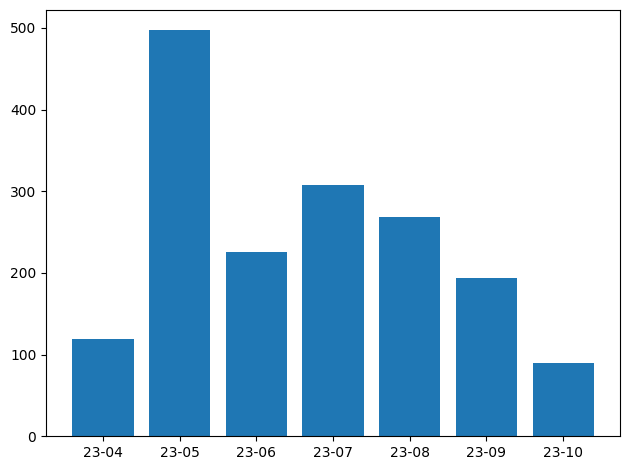

In [7]:
# Display pumps in last 6 months
df = result_df
df['legend'] = df.apply(lambda x: x['year/month'][2:], axis=1)
print(df.tail(12))

fig, ax = plt.subplots()
ax.bar(df['legend'], df['pumps'])

plt.tight_layout() 
plt.show()
# 42 56 41 18

In [8]:
# Generate files and charts for variety of configs


def get_df_candles_pumps(
    daily_candles: Dict[str, List[List[any]]], 
    df_charts: Dict[str, pd.DataFrame], pump_ratio: float, min_volume: float
) -> Dict[str, pd.DataFrame]:
    df_candles_pumps: Dict[str, pd.DataFrame] = dict()
    for idx, key in enumerate(daily_candles):
        candles = daily_candles[key]
        print_progress("Searching for pumps", idx, len(daily_candles), True)
        if key not in df_charts: 
            continue    
        df_chart = df_charts[key]
        df_candles_pumps[key] = daily_candle_pumps_info(candles, pump_ratio, min_volume, df_chart)
    return df_candles_pumps


def get_df_candles_pumps_plot(df_candles_pumps: Dict[str, pd.DataFrame])-> pd.DataFrame:
    keys = year_month_keys(list(range(2023, 2024)), list(range(4, 11)))
    df = pd.DataFrame(data={
        'year/month': keys, 
        "pumps": np.zeros(len(keys)), 
        "markets": map(lambda x: "", np.zeros(len(keys)))
    })
    for idx, key in enumerate(keys):
        for df_key in df_candles_pumps:
            df_candles_pump = df_candles_pumps[df_key]
            pump_cnt = df_candles_pump.loc[df_candles_pump['Ym'] == key].shape[0]
            if pump_cnt > 0:
                df.loc[df['year/month'] == key, 'pumps'] += pump_cnt
                df.loc[df['year/month'] == key, 'markets'] += "{}, ".format(df_key)
    
        print_progress("Counting for pumps", idx, len(keys), True)    
    return df


def plot_df(df: pd.DataFrame):
    df['legend'] = df.apply(lambda x: x['year/month'][2:], axis=1)
    print(df.tail(12))
    fig, ax = plt.subplots()
    ax.bar(df['legend'], df['pumps'])
    plt.tight_layout() 
    plt.show()
    
    
def write_pump_to_file(df: pd.DataFrame, pump_ratio: float, min_volume: float):
    results = read_json_file_or_empty_list('results/candle_info.json')
    info = dict()
    pump_count_for_month = dict()
    pump_coins_for_month = dict()
    for key in df['year/month'].values:
        row = df.loc[df['year/month'] == key]
        pump_count_for_month[key] = row['pumps'].values[0]
        pump_coins_for_month[key] = row['markets'].values[0].split(', ')[:-1]    
    info['pump_ratio'] = pump_ratio 
    info['min_volume'] = min_volume
    info['pump_count_for_month'] = pump_count_for_month
    info['pump_coins_for_month'] = pump_coins_for_month
    results.append(info)
    write_json_file('results/candle_info.json', results)


pd.set_option('display.width', 256)
pd.set_option('display.max_colwidth', 80)

pump_ratios = [1.5, 2.0, 4.0, 8.0]
min_volumes = [100000, 500000, 1000000, 10000000]
keys = year_month_keys(list(range(2017, 2024)), list(range(1, 13)))
ratio_results = dict()

for pump_ratio in pump_ratios:
    volume_results = dict()
    for min_volume in min_volumes:
        print("Pump ratio: {}, Min Volume: {}".format(pump_ratio, min_volume))
        df_candles_pumps = get_df_candles_pumps(daily_candles, df_charts, pump_ratio, min_volume)
        df_candles_pumps_plot = get_df_candles_pumps_plot(df_candles_pumps)
        # plot_df(df_candles_pumps_plot)
        write_pump_to_file(df_candles_pumps_plot, pump_ratio, min_volume)
        volume_results[min_volume] = df_candles_pumps_plot
    ratio_results[pump_ratio] = volume_results

pd.reset_option('display.width')
pd.reset_option('display.max_colwidth')

Pump ratio: 1.5, Min Volume: 100000
 Counting for pumps idx: 6 / 7, 85.7%       Pump ratio: 1.5, Min Volume: 500000
 Counting for pumps idx: 6 / 7, 85.7%       Pump ratio: 1.5, Min Volume: 1000000
 Counting for pumps idx: 6 / 7, 85.7%       Pump ratio: 1.5, Min Volume: 10000000
 Counting for pumps idx: 6 / 7, 85.7%       Pump ratio: 2.0, Min Volume: 100000
 Counting for pumps idx: 6 / 7, 85.7%       Pump ratio: 2.0, Min Volume: 500000
 Counting for pumps idx: 6 / 7, 85.7%       Pump ratio: 2.0, Min Volume: 1000000
 Counting for pumps idx: 6 / 7, 85.7%       Pump ratio: 2.0, Min Volume: 10000000
 Counting for pumps idx: 6 / 7, 85.7%       Pump ratio: 4.0, Min Volume: 100000
 Counting for pumps idx: 6 / 7, 85.7%       Pump ratio: 4.0, Min Volume: 500000
 Counting for pumps idx: 6 / 7, 85.7%       Pump ratio: 4.0, Min Volume: 1000000
 Counting for pumps idx: 6 / 7, 85.7%       Pump ratio: 4.0, Min Volume: 10000000
 Counting for pumps idx: 6 / 7, 85.7%       Pump ratio: 8.0, Min Volume: 10

Pump ratio 1.5x
                   100K        500K     1M        10M
year/month                                           
2023-05     1054.000000  497.000000  341.0  70.000000
2023-06      621.000000  226.000000  139.0  26.000000
2023-07      771.000000  308.000000  202.0  46.000000
2023-08      664.000000  269.000000  170.0  31.000000
2023-09      582.000000  194.000000  126.0  34.000000
2023-10      257.000000   90.000000   60.0  16.000000
MEAN         605.571429  243.285714  160.0  34.571429
MEDIAN       621.000000  226.000000  139.0  31.000000


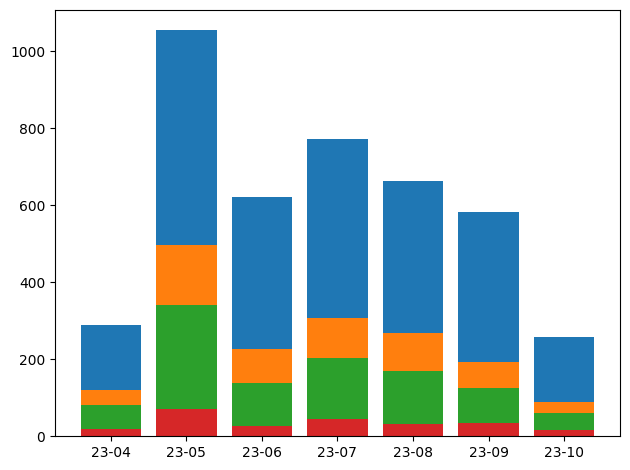

Pump ratio 2.0x
                  100K        500K          1M        10M
year/month                                               
2023-05     411.000000  205.000000  145.000000  29.000000
2023-06     233.000000   85.000000   61.000000  10.000000
2023-07     255.000000  111.000000   77.000000  11.000000
2023-08     210.000000   86.000000   56.000000   6.000000
2023-09     201.000000   66.000000   41.000000   9.000000
2023-10      92.000000   30.000000   18.000000   5.000000
MEAN        217.428571   90.428571   61.857143  10.857143
MEDIAN      210.000000   85.000000   56.000000   9.000000


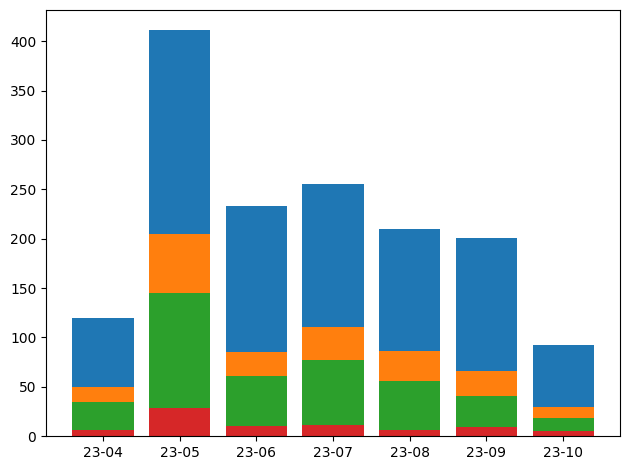

Pump ratio 4.0x
                  100K       500K         1M       10M
year/month                                            
2023-05     100.000000  47.000000  33.000000  9.000000
2023-06      55.000000  16.000000   9.000000  3.000000
2023-07      49.000000  19.000000  12.000000  1.000000
2023-08      41.000000   8.000000   4.000000  0.000000
2023-09      48.000000  17.000000  10.000000  2.000000
2023-10      29.000000   6.000000   4.000000  1.000000
MEAN         50.285714  17.428571  11.428571  2.428571
MEDIAN       48.000000  16.000000   9.000000  1.000000


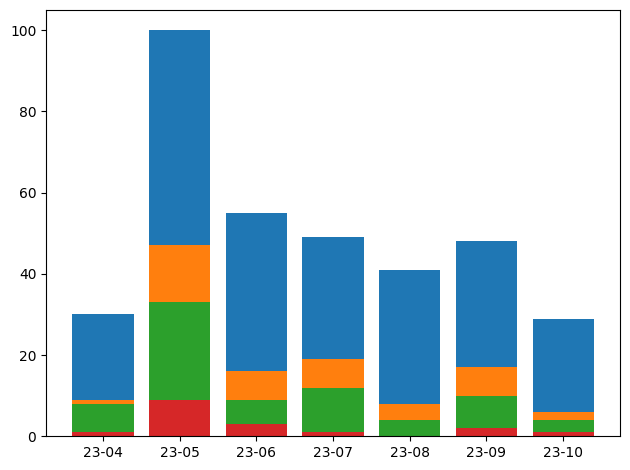

Pump ratio 8.0x
            100K       500K        1M  10M
year/month                                
2023-05     39.0  14.000000  8.000000  2.0
2023-06     32.0   8.000000  5.000000  2.0
2023-07     21.0   8.000000  6.000000  1.0
2023-08     27.0   6.000000  2.000000  0.0
2023-09     21.0   7.000000  6.000000  1.0
2023-10     20.0   4.000000  3.000000  1.0
MEAN        25.0   7.142857  4.571429  1.0
MEDIAN      21.0   7.000000  5.000000  1.0


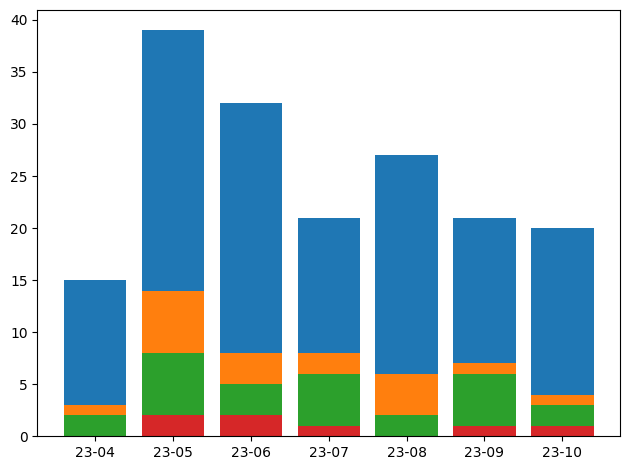

In [13]:
def plot_ratio(ratio: float, volume: Dict[int, pd.DataFrame]):
    fig, ax = plt.subplots()
    for volume_key in volume_results:
        df = volume_results[volume_key]
        df['legend'] = df.apply(lambda x: x['year/month'][2:], axis=1)
        ax.bar(df['legend'], df['pumps'])
    plt.tight_layout() 
    plt.show()


def print_data(ratio: float, volume_results: Dict[int, pd.DataFrame], keep_market: bool = False):
    merged_df = None
    for volume_key in volume_results:
        df = volume_results[volume_key]
        df['legend'] = df.apply(lambda x: x['year/month'][2:], axis=1)
        df = df.set_index('year/month')
        row = pd.DataFrame(data={
            'year/month': ['MEAN', 'MEDIAN'], 
            'pumps': [df.loc[:, 'pumps'].mean(), df.loc[:, 'pumps'].median()]
        })
        row = row.set_index('year/month')
        df = pd.concat([df, row])
        df = df.rename(columns={'pumps': large_num_short_format(volume_key)})
        if keep_market:
            df = df.rename(columns={'markets': large_num_short_format(volume_key)})
            df = df.drop(['legend'], axis=1)
        else:
            df = df.drop(['markets', 'legend'], axis=1)
        if merged_df is None:
            merged_df = df
        else:
            merged_df = merged_df.join(df)
    extra = '_mrk' if keep_market else '' 
    merged_df.to_csv('results/candle_ratio_' + str(ratio) + extra + '.csv', index=True)    
    print(merged_df.tail(8))
     
for ratio_key in ratio_results:
    print("Pump ratio {}x".format(ratio_key))
    volume_results = ratio_results[ratio_key]
    print_data(ratio_key, volume_results)
    plot_ratio(ratio_key, volume_results)    